In [34]:
%matplotlib inline

In [37]:
import os
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2

from src.utils.vocab import Vocab
from src.utils.dataset import Dataset

In [29]:
debug = False
data_dir = "data/"
snli_dir = os.path.join(data_dir, "snli_1.0")
vocab_file = os.path.join(data_dir, "vocab.txt")
regular_data_file = os.path.join(data_dir, "data.pkl")
debug_data_file = os.path.join(data_dir, "debug_data.pkl")
models_dir = os.path.join(data_dir, "models")
max_seq_len = 100

In [ ]:
vocab = Vocab(snli_dir, vocab_file)
dataset = Dataset(snli_dir, regular_data_file, debug_data_file, vocab,
                  max_seq_len, debug=debug)

In [16]:
train_set_len, dev_set_len, test_set_len = dataset.split_size("train"), dataset.split_size("dev"), dataset.split_size("test")
print "Split sizes. Train: %s, dev: %s, test: %s" % (train_set_len, dev_set_len, test_set_len)

Split sizes. Train: 549367, dev: 9842, test: 9824


In [26]:
# Example sentences from the dev set
print "A few examples from the dev set."
for i in range(4):
    print "%s)" % (i + 1)
    x = random.randint(0, dev_set_len - 1)
    sentence1 = dataset.get_sentence1("dev")[x]
    sentence2 = dataset.get_sentence2("dev")[x]
    label = dataset.int_to_label(dataset.get_true_labels("dev")[x])
    print "Premise: %s" % sentence1
    print "Hypothesis: %s" % sentence2
    print "Label: %s" % label
    print

A few examples from the dev set.
1)
Premise: A girls sports team putting their hands in a circle to do a bonding cheer.
Hypothesis: Cheerleaders doing a cheer
Label: neutral

2)
Premise: A man wearing shorts is playing an acoustic guitar while a person in the background looks the other way.
Hypothesis: two women sing opera
Label: contradiction

3)
Premise: Two young men in black tank tops playing on a set of drums.
Hypothesis: Some guys in black beat their drums.
Label: entailment

4)
Premise: The lady in the red jacket is helping the other lady decide what to buy.
Hypothesis: There are multiple people present.
Label: entailment



In [71]:
model_names = ["mpm", "varunchena", "stk"]
model_predictions = {name: np.load(os.path.join(models_dir, os.path.join(name, "results/predictions_dev.npy")))
                     for name in model_names}

In [72]:
# As a sanity check, recompute accuracies
for name in model_names:
    print "Model: %s" % name
    predictions = model_predictions[name]
    true_labels = dataset.get_true_labels("dev")
    accuracy = np.sum(predictions == true_labels, dtype=np.float32) / np.sum(predictions.shape)
    print "Accuracy: %s" % accuracy

Model: mpm
Accuracy: 0.844442186547
Model: varunchena
Accuracy: 0.867709815078
Model: stk
Accuracy: 0.841597236334


In [73]:
def venn_diagram(model_predictions, split, name1, name2, name3=None):
    true_labels = dataset.get_true_labels(split)
    split_len = dataset.split_size(split)

    predictions1 = model_predictions[name1]
    predictions2 = model_predictions[name2]
    if name3 is not None:
        predictions3 = model_predictions[name3]

    incorrect1 = set(np.nonzero(predictions1 != true_labels)[0])
    incorrect2 = set(np.nonzero(predictions2 != true_labels)[0])
    if name3 is not None:
        incorrect3 = set(np.nonzero(predictions3 != true_labels)[0])

    plt.figure();
    if name3 is None:
        venn2([incorrect1, incorrect2], (name1, name2))
    else:
        venn3([incorrect1, incorrect2, incorrect3], (name1, name2, name3))

    plt.show()

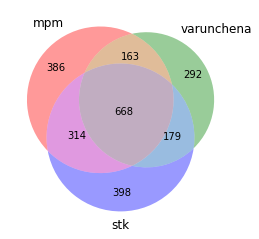

In [74]:
venn_diagram(model_predictions, "dev", "mpm", "varunchena", "stk")

In [75]:
def hard_indices(model_predictions, split, names):
    true_labels = dataset.get_true_labels(split)
    split_len = dataset.split_size(split)

    incorrects = {name: set(np.nonzero(model_predictions[name] != true_labels)[0]) for name in names}
    hi = set(range(split_len))
    for name in names:
        hi &= incorrects[name]

    return hi

In [101]:
def confidence(split, idx):
    annotations = list(dataset._dataframes[split]["annotator_labels"])
    gold_label = list(dataset._dataframes[split]["gold_label"])[idx]
    return sum(1 for i in range(5) if annotations[idx][i] == gold_label)

In [87]:
def show_examples_with_preds(model_predictions, split, names, indices):
    sentence1s = dataset.get_sentence1(split)
    sentence2s = dataset.get_sentence2(split)
    true_labels = dataset.get_true_labels(split)
    split_len = dataset.split_size(split)

    for i, idx in enumerate(indices):
        print "%s)" % (i + 1)
        print "Premise: %s" % sentence1s[idx]
        print "Hypothesis: %s" % sentence2s[idx]
        print "Label: %s" % dataset.int_to_label(true_labels[idx])
        print "Annotator confidence: %s/5" % confidence(split, idx)
        for name in names:
            print "Model %s prediction: %s" % (name, dataset.int_to_label(model_predictions[name][idx]))
        print

In [102]:
hi = hard_indices(model_predictions, "dev", model_names)
samples = random.sample(hi, 5)
show_examples_with_preds(model_predictions, "dev", model_names, samples)

1)
Premise: A man at the beach, building a sand castle.
Hypothesis: A man is using buckets and a shovel.
Label: neutral
Annotator confidence: 4/5
Model mpm prediction: contradiction
Model varunchena prediction: contradiction
Model stk prediction: contradiction

2)
Premise: Rival female basketball teams are playing a game in front of an audience at an indoor arena.
Hypothesis: Two female basketball teams are both trying to win the game.
Label: entailment
Annotator confidence: 4/5
Model mpm prediction: neutral
Model varunchena prediction: neutral
Model stk prediction: neutral

3)
Premise: Two pedestrians walking past a sidewalk cafe on a cobblestone street.
Hypothesis: two pedestrians walk on a cobblestone road a long way away from a cafe
Label: contradiction
Annotator confidence: 3/5
Model mpm prediction: neutral
Model varunchena prediction: entailment
Model stk prediction: neutral

4)
Premise: A woman and a man are sword fighting.
Hypothesis: Two people have engaged in a sword fight an